# Feature Selection 2

### All Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown
from glob import glob
from word_list.basic import politics1, politics2
from word_list.basic import business, control

In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

## Variables

In [2]:
TRAIN_DATE_FIRST = "2004-01-04" 
TRAIN_DATE_LAST = "2012-12-16" 
INSTRUMENT = "es1"
INSTRUMENT_PRICE_COLUMN = 'PX_LAST'
INSTRUMENT_DATE_COLUMN = 'date'

### Functions

In [3]:
def show_results(results, top_n, number, ascending):

    display(Markdown("#### {}.1) Top {} Features".format(number, top_n)))
    display(HTML(results.head(top_n).to_html()))

    display(Markdown(""))

    display(Markdown("#### {}.2) Bottom {} Features".format(number, top_n)))
    display(HTML(results.tail(top_n).to_html()))

    display(Markdown(""))

    word_rank = results.groupby("word").mean(
    ).score.sort_values(ascending=ascending).to_frame()
    
    display(Markdown("#### {}.3) Top {} words".format(number, top_n)))
    display(HTML(word_rank.head(top_n).to_html()))
    display(Markdown("#### {}.4) Bottom {} words".format(number, top_n)))
    display(HTML(word_rank.tail(top_n).to_html()))

    politics1_rank = word_rank.loc[politics1].values.flatten()
    politics2_rank = word_rank.loc[politics2].values.flatten()

    # hack. We have a problem with the word "notability"
    politics2_rank = np.concatenate([politics2_rank, [float("nan")]])

    business_rank = word_rank.loc[business].values.flatten()
    control_rank = word_rank.loc[control].values.flatten()

    method_cat = np.stack([politics1_rank,
                           politics2_rank,
                           business_rank,
                           control_rank], 1)
    method_cat = pd.DataFrame(method_cat, columns=["Politics1",
                                                   "Politics2",
                                                   "Business",
                                                   "Control"])

    fig, ax = plt.subplots(figsize=(10, 5))
    results.score.hist(ax=ax)
    ax.set_title(
        "{}.5) Method {} score distribution".format(
            number,
            number),
        fontsize=18)

    fig, ax = plt.subplots(figsize=(10, 5))
    word_rank.score.hist(ax=ax)
    ax.set_title("{}.6) Method {} word score distribution".format(number,
                                                                  number), fontsize=18)

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=method_cat, orient="h", palette="Set2", ax=ax)
    ax.set_title("{}.7) Method {} score distribution for each category".format(number,
                                                                               number), fontsize=18)


## Loading market data and defining return variable

For a day $t$, and an instrument with price $P_t$, we define the target variable $R_t$ as the *simple return*:

\begin{equation}
R_t = \frac{(P_t - P_{t-1})}{P_{t-1}}
\end{equation}

### es1 target data (2004 - 2012)

,es1_returns
date,
2004-01-05,0.009919
2004-01-06,0.001782
2004-01-07,0.003123
2004-01-08,0.003556
2004-01-09,-0.008413


#### shape = (2273, 1)

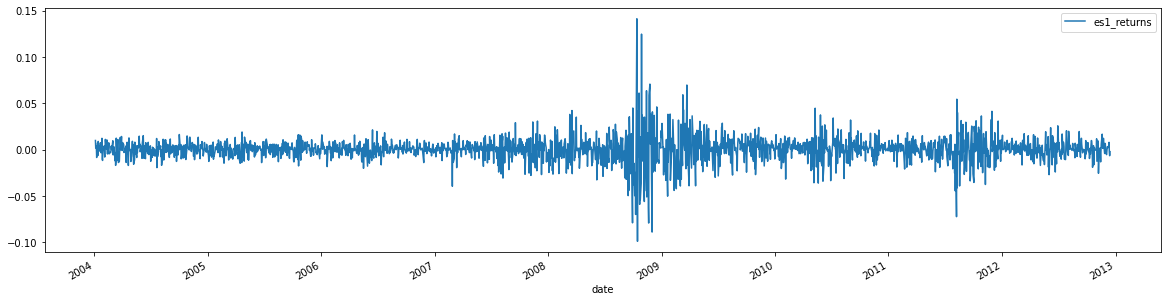

In [4]:
market_path = os.path.join('data','market',"{}.txt".format(INSTRUMENT))
df_market = pd.read_csv(market_path, sep='\t')
df_market.loc[:, INSTRUMENT_DATE_COLUMN] = pd.to_datetime(df_market[INSTRUMENT_DATE_COLUMN])
df_market = df_market.set_index(INSTRUMENT_DATE_COLUMN)
close = df_market[[INSTRUMENT_PRICE_COLUMN]].dropna()
target = close.pct_change().dropna()
target_name = "{}_returns".format(INSTRUMENT) 
target.columns = [target_name]
target = target[TRAIN_DATE_FIRST: TRAIN_DATE_LAST]

display(Markdown("### {} target data ({} - {})".format(INSTRUMENT,
                                                       TRAIN_DATE_FIRST.split("-")[0],
                                                       TRAIN_DATE_LAST.split("-")[0])))
display(HTML(target.head(5).to_html()))
display(Markdown("#### shape = {}".format(target.shape)))
display(Markdown(" "))
fig, ax = plt.subplots(figsize=(20,5))
target.plot(ax=ax);

## Google trends data

Let ${S^{w}}_t$ be the search interest in the word $w$ at day $t$.

### Google trends data (2004 - 2012)

,BUY_AND_HOLD,DOW_JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,buy,cancer,car,carolina,case,cash,ceo,chance,college,color,committee,community,companies,conflict,consume,consumption,conty,corporation,council,county,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,development,district,dividend,dow_jones,earnings,earths,economic,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial,fine,firm,fond,food,forex,founded,freedom,fun,gain,gains,garden,georgia,global,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inc,industry,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,ltd,management,market,marketing,markets,marriage,massachusetts,media,members,metals,million,minister,ministry,missouri,money,movement,movie,nasdaq,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,products,profit,project,rare,religion,representatives,republican,restaurant,return,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,selling,senate,served,service,services,short,social,society,stats,stock,stocks,success,technology,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermont,vermount,virginia,voter,voters,votes,war,washington,water,william,winsconsin,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-04,1.0,1.0,18.0,26.0,57.0,5.0,0.0,6.0,6.0,51.0,81.0,17.0,84.0,51.0,26.0,10.0,1.0,3.0,68.0,27.0,3.0,50.0,18.0,4.0,1.0,3.0,0.0,13.0,10.0,67.0,27.0,10.0,53.0,3.0,7.0,5.0,7.0,8.0,2.0,19.0,31.0,2.0,1.0,1.0,0.0,5.0,3.0,4.0,1.0,4.0,1.0,18.0,4.0,3.0,29.0,5.0,17.0,13.0,4.0,0.0,61.0,1.0,1.0,8.0,18.0,4.0,2.0,23.0,46.0,12.0,30.0,21.0,2.0,1.0,8.0,12.0,1.0,55.0,1.0,21.0,100.0,86.0,11.0,43.0,28.0,9.0,1.0,1.0,8.0,3.0,8.0,14.0,26.0,13.0,46.0,11.0,1.0,2.0,14.0,5.0,26.0,25.0,9.0,3.0,19.0,26.0,43.0,6.0,3.0,5.0,3.0,3.0,20.0,29.0,3.0,83.0,2.0,1.0,62.0,60.0,24.0,3.0,1.0,41.0,26.0,32.0,10.0,2.0,2.0,3.0,10.0,27.0,2.0,31.0,5.0,7.0,2.0,5.0,38.0,24.0,1.0,7.0,7.0,14.0,35.0,6.0,6.0,4.0,30.0,11.0,6.0,2.0,1.0,79.0,38.0,22.0,21.0,32.0,8.0,26.0,6.0,3.0,24.0,21.0,70.0,8.0,9.0,26.0,0.0,57.0,10.0,37.0,16.0,1.0,56.0,1.0,1.0,1.0,60.0,68.0,48.0,34.0,1.0,29.0,87.0,85.0
2004-01-05,0.0,1.0,21.0,29.0,50.0,2.0,0.0,5.0,3.0,52.0,71.0,23.0,82.0,47.0,26.0,10.0,4.0,2.0,100.0,34.0,4.0,88.0,19.0,2.0,0.0,5.0,0.0,10.0,11.0,71.0,28.0,14.0,55.0,2.0,9.0,6.0,5.0,9.0,0.0,19.0,58.0,2.0,2.0,3.0,1.0,6.0,5.0,3.0,2.0,5.0,2.0,11.0,6.0,2.0,25.0,5.0,18.0,6.0,8.0,0.0,57.0,0.0,3.0,8.0,23.0,5.0,1.0,20.0,38.0,10.0,33.0,25.0,5.0,1.0,6.0,8.0,1.0,54.0,2.0,21.0,87.0,79.0,11.0,36.0,30.0,7.0,4.0,1.0,10.0,5.0,5.0,14.0,22.0,11.0,52.0,16.0,0.0,2.0,15.0,4.0,36.0,22.0,13.0,3.0,34.0,24.0,43.0,5.0,1.0,4.0,3.0,6.0,20.0,29.0,6.0,73.0,3.0,2.0,54.0,49.0,23.0,4.0,2.0,30.0,21.0,30.0,7.0,5.0,3.0,2.0,13.0,29.0,2.0,28.0,5.0,7.0,2.0,6.0,30.0,22.0,2.0,5.0,8.0,12.0,37.0,2.0,4.0,3.0,35.0,7.0,2.0,2.0,2.0,70.0,44.0,20.0,17.0,33.0,6.0,29.0,6.0,3.0,21.0,19.0,66.0,12.0,13.0,18.0,2.0,60.0,4.0,31.0,12.0,0.0,57.0,2.0,2.0,2.0,64.0,67.0,51.0,39.0,0.0,30.0,91.0,70.0
2004-01-06,0.0,2.0,31.0,30.0,87.0,7.0,0.0,4.0,4.0,86.0,66.0,27.0,78.0,57.0,26.0,11.0,3.0,2.0,89.0,32.0,9.0,87.0,32.0,3.0,1.0,1.0,1.0,37.0,19.0,96.0,48.0,10.0,74.0,3.0,13.0,5.0,7.0,7.0,1.0,33.0,62.0,2.0,2.0,1.0,1.0,10.0,7.0,6.0,1.0,7.0,2.0,24.0,8.0,6.0,54.0,16.0,36.0,8.0,7.0,2.0,62.0,1.0,2.0,7.0,17.0,4.0,1.0,21.0,62.0,19.0,23.0,36.0,6.0,1.0,11.0,10.0,1.0,94.0,2.0,28.0,87.0,85.0,12.0,50.0,56.0,14.0,2.0,2.0,10.0,4.0,9.0,16.0,16.0,16.0,66.0,22.0,0.0,3.0,13.0,10.0,59.0,32.0,21.0,5.0,17.0,34.0,42.0,6.0,3.0,5.0,1.0,6.0,25.0,27.0,4.0,45.0,3.0,2.0,100.0,82.0,27.0,2.0,1.0,36.0,34.0,35.0,12.0,4.0,5.0,2.0,18.0,37.0,5.0,38.0,3.0,5.0,4.0,7.0,47.0,15.0,2.0,11.0,8.0,17.0,24.0,10.0

#### shape = (3270, 186)

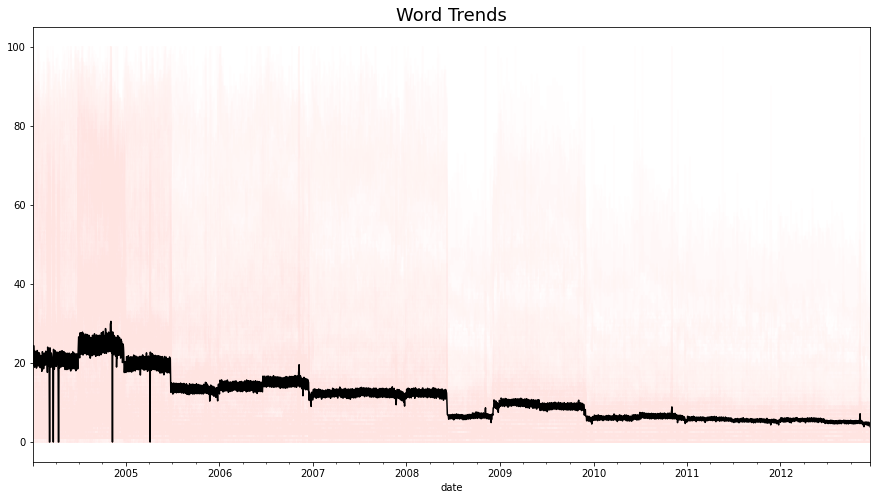

In [5]:
trends_path = os.path.join('data','daily_trend',"*.csv")
daily_dfs_path =  glob(trends_path)
daily_dfs_path.sort()
daily_dfs = [pd.read_csv(path) for path in daily_dfs_path]
daily_dfs_names = [i.split("/")[2] for i in daily_dfs_path]
daily_dfs_names = [i.split(".")[0] for i in daily_dfs_names]

trends_list = []
for name, df in zip(daily_dfs_names, daily_dfs):
    df.index = pd.to_datetime(df.date)
    ts = df[name]
    new_name = name.replace(" ", "_")
    ts.name = new_name
    trends_list.append(ts)

trends = pd.concat(trends_list,1)
trends = trends.fillna(0.0)
words = list(trends.columns)
words.sort()
words.remove("notability") # only zero info in this dataset
politics2 = [w for w in politics2 if w != "notability"] # only zero info in this dataset

trends = trends[words]
trends = trends[TRAIN_DATE_FIRST: TRAIN_DATE_LAST]


display(Markdown("### Google trends data ({} - {})".format(TRAIN_DATE_FIRST.split("-")[0],
                                                           TRAIN_DATE_LAST.split("-")[0])))
display(HTML(trends.head(5).to_html()))
display(Markdown("#### shape = {}".format(trends.shape))) 

fig, ax = plt.subplots(figsize=(15,8))
trends.plot(ax=ax,legend=False,alpha= 0.05,  color="mistyrose");
trends.mean(1).plot(ax=ax,legend=False, color="k", label="mean trend");
ax.set_title("Word Trends", fontsize=18);

## Creating Features

For $k \in \{1, \dots, K\}$ and word $w$, we define the word feature ${D^{w}}_t$ as the $k$ difference:

\begin{equation}
{D^{w}}_{k,t} = {S^{w}}_t - {S^{w}}_{t-k}
\end{equation}


In [6]:
K = 30
features_list = []

for k in range(1, K+1):
    feat = trends.diff(k).add_suffix('_diff_{}'.format(k))
    features_list.append(feat)
    
trend_features = pd.concat(features_list, 1)

display(Markdown("### Word Features"))
display(HTML(trend_features.head(5).to_html()))
display(Markdown("#### shape = {}".format(trend_features.shape)))

### Word Features

#### shape = (3270, 5580)

## Method 1 Results

#### 1.1) Top 10 Features

,word,k,score
0,dow_jones,19,0.068673
1,election,21,0.061354
2,DOW_JONES,19,0.060716
3,debt,20,0.059229
4,DOW_JONES,7,0.059183
5,election,20,0.056165
6,food,3,0.054825
7,debt,13,0.053229
8,food,4,0.052650
9,election,27,0.052403


#### 1.2) Bottom 10 Features

,word,k,score
5570,investment,22,1.745550e-05
5571,success,22,1.719511e-05
5572,marketing,11,1.195299e-05
5573,portfolio,5,9.318088e-06
5574,act,25,9.186686e-06
5575,tourism,26,8.555287e-06
5576,economic,27,6.021531e-06
5577,products,6,1.870256e-06
5578,headlines,10,1.219433e-06
5579,council,19,7.812569e-07


#### 1.3) Top 10 words

,score
word,
holiday,0.027820
cash,0.025649
food,0.025138
markets,0.024905
election,0.023893
kentucky,0.023633
world,0.023051
debt,0.022984
risk,0.022044


#### 1.4) Bottom 10 words

,score
word,
tourism,0.006630
war,0.006588
ministry,0.006574
sell,0.006381
judge,0.006072
economy,0.005797
conty,0.005735
voters,0.005554
default,0.005516


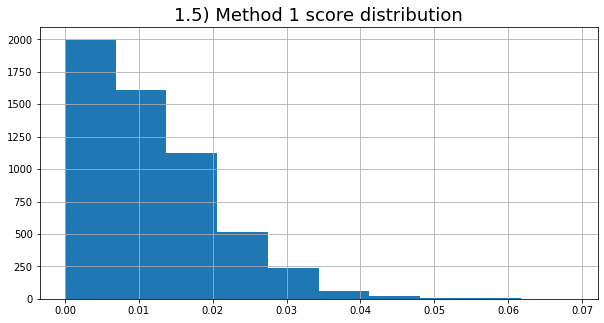

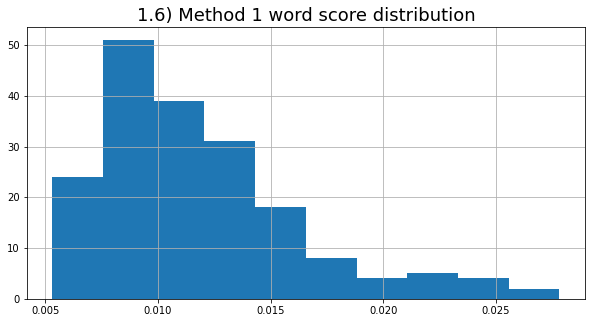

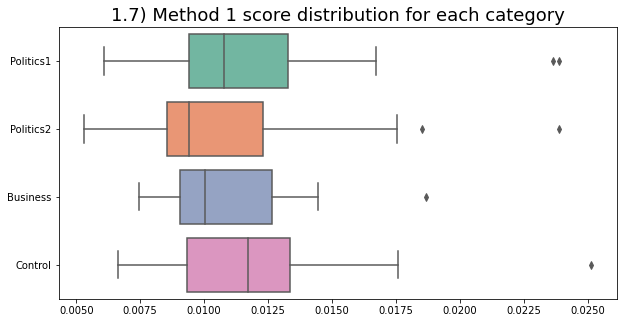

In [7]:
results1 = pd.read_csv("results/method_1.csv")
show_results(results1,10,1, ascending=False)

## Method 2 Results

### Method 2 Results with Lag

,word,k,lag,score
0,dow_jones,12,7,0.106202
1,DOW_JONES,12,7,0.103888
2,dow_jones,11,8,0.102046
3,DOW_JONES,21,7,0.101689
4,dow_jones,21,7,0.099045
5,dow_jones,8,8,0.098713
6,dow_jones,7,9,0.093934
7,DOW_JONES,11,8,0.090467
8,DOW_JONES,20,7,0.090199
9,dow_jones,20,7,0.087072


#### 1.1) Top 10 Features

,word,k,score
0,dow_jones,7,0.039700
1,dow_jones,13,0.038776
2,dow_jones,9,0.037487
3,DOW_JONES,7,0.037262
4,DOW_JONES,13,0.037182
5,DOW_JONES,19,0.036967
6,DOW_JONES,12,0.036916
7,dow_jones,12,0.036729
8,dow_jones,19,0.036066
9,dow_jones,8,0.036004


#### 1.2) Bottom 10 Features

,word,k,score
5570,development,28,0.004015
5571,gold,20,0.004005
5572,media,24,0.003877
5573,political,29,0.003761
5574,greed,20,0.003661
5575,greed,13,0.003597
5576,voters,18,0.003552
5577,hedge,21,0.003514
5578,voters,19,0.002915
5579,BUY_AND_HOLD,30,0.002859


#### 1.3) Top 10 words

,score
word,
dow_jones,0.030893
DOW_JONES,0.029828
debt,0.023290
election,0.022201
buy,0.020274
stock,0.020175
representatives,0.018479
holiday,0.018327
politics,0.017857


#### 1.4) Bottom 10 words

,score
word,
gold,0.007769
garden,0.007736
blacklist,0.007687
economy,0.007538
BUY_AND_HOLD,0.007280
judge,0.007217
republican,0.007216
greed,0.007205
voters,0.006573


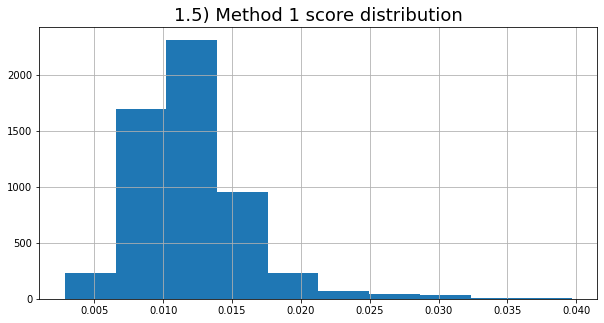

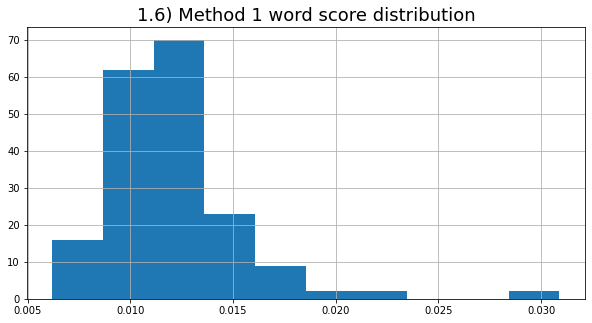

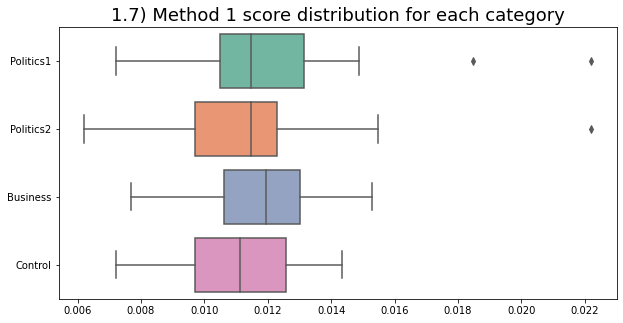

In [8]:
raw_results2 = pd.read_csv("results/method_2.csv")

raw_results2_s = raw_results2.set_index(["word", "k", "lag"]).sort_index()

results2 = []

for w in words:
    for k in range(1, K+1):
        score = raw_results2_s.xs((w,k)).mean()[0]
        obs = (w,k,score)
        results2.append(obs)

results2 = pd.DataFrame(results2, columns=["word","k","score"])
results2 = results2.sort_values("score",ascending=False)
results2 = results2.reset_index(drop=True)



display(Markdown("### Method 2 Results with Lag"))
display(HTML(raw_results2.head(10).to_html()))

show_results(results2,10,1,ascending=False)

## Method 3 Results

#### 3.1) Top 10 Features

,word,k,score
0,markets,4,0.000185
1,food,4,0.000185
2,kentucky,4,0.000185
3,food,3,0.000185
4,invest,3,0.000185
5,markets,10,0.000185
6,oil,6,0.000185
7,banking,7,0.000185
8,markets,2,0.000185
9,million,8,0.000185


#### 3.2) Bottom 10 Features

,word,k,score
5570,election,26,0.000187
5571,election,22,0.000187
5572,election,23,0.000187
5573,revenue,21,0.000187
5574,DOW_JONES,30,0.000187
5575,dow_jones,24,0.000187
5576,revenue,22,0.000187
5577,election,16,0.000187
5578,DOW_JONES,24,0.000187
5579,election,17,0.000187


#### 3.3) Top 10 words

,score
word,
markets,0.000186
holiday,0.000186
food,0.000186
debt,0.000186
cash,0.000186
religion,0.000186
leverage,0.000186
ceo,0.000186
kentucky,0.000186


#### 3.4) Bottom 10 words

,score
word,
nasdaq,0.000186
elected,0.000186
politics,0.000186
dow_jones,0.000186
elections,0.000186
votes,0.000186
president,0.000186
DOW_JONES,0.000186
revenue,0.000186


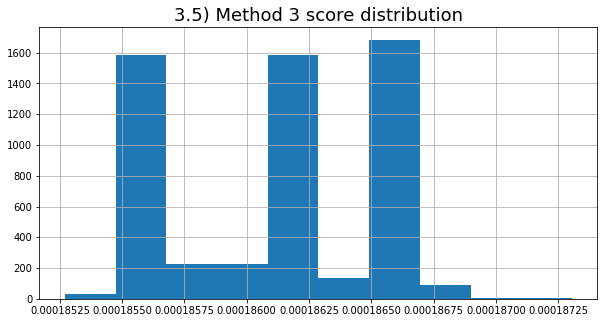

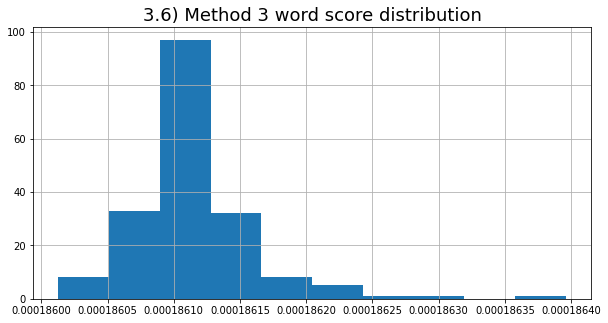

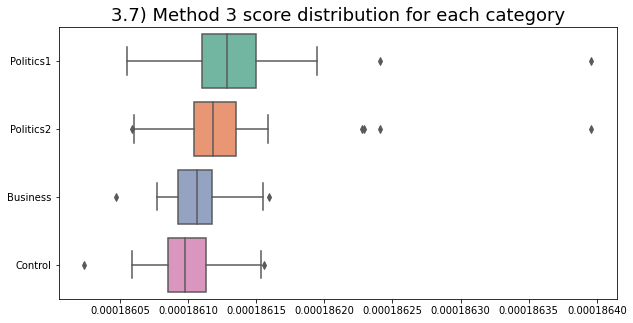

In [9]:
results3 = pd.read_csv("results/method_3.csv")
show_results(results3,10,3,ascending=True)

## Method 4 Results

### Method 4 Results with Lag

,word,k,lag,score
0,nasdaq,6,2,0.000185
1,finance,6,2,0.000185
2,metals,6,2,0.000185
3,nasdaq,7,2,0.000185
4,markets,4,1,0.000185
5,food,4,1,0.000185
6,nasdaq,5,2,0.000185
7,world,3,3,0.000185
8,nasdaq,8,2,0.000185
9,kentucky,4,1,0.000185


#### 4.1) Top 10 Features

,word,k,score
0,crash,1,0.000187
1,crisis,1,0.000187
2,gains,1,0.000187
3,environment,1,0.000187
4,color,1,0.000187
5,market,1,0.000187
6,fed,1,0.000187
7,BUY_AND_HOLD,1,0.000187
8,party,1,0.000187
9,winsconsin,1,0.000187


#### 4.2) Bottom 10 Features

,word,k,score
5570,happy,30,0.000188
5571,gain,30,0.000188
5572,unemployment,30,0.000188
5573,bank,30,0.000188
5574,dow_jones,30,0.000188
5575,DOW_JONES,24,0.000188
5576,county,30,0.000188
5577,DOW_JONES,30,0.000188
5578,election,30,0.000188
5579,dividend,30,0.000188


#### 4.3) Top 10 words

,score
word,
water,0.000187
arts,0.000187
consume,0.000187
movement,0.000187
religion,0.000187
BUY_AND_HOLD,0.000187
holiday,0.000187
william,0.000187
color,0.000187


#### 4.4) Bottom 10 words

,score
word,
president,0.000187
hedge,0.000187
revenue,0.000187
elected,0.000187
dividend,0.000187
unemployment,0.000187
county,0.000187
election,0.000187
dow_jones,0.000187


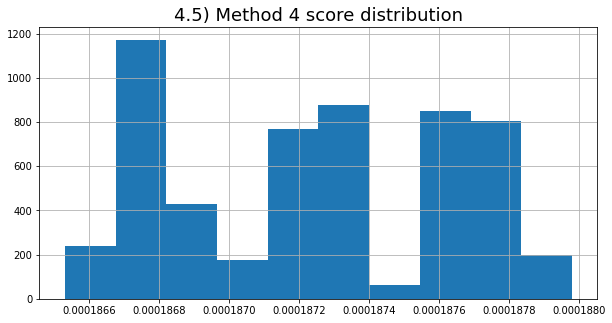

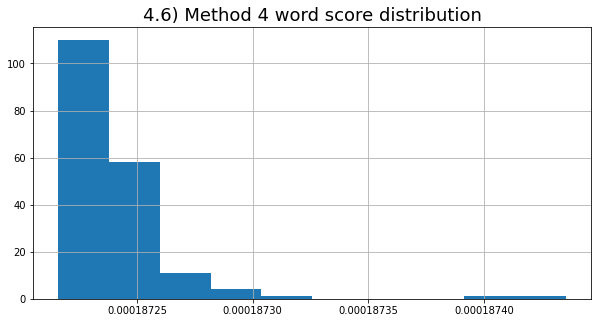

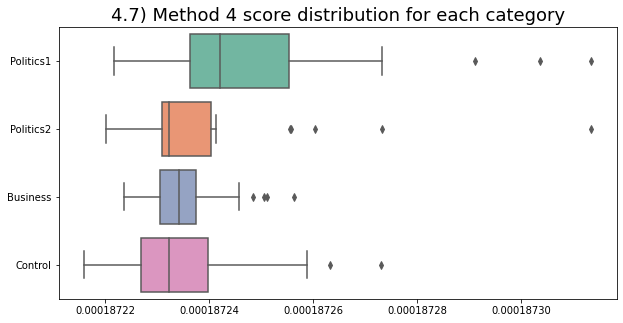

In [10]:
raw_results4 = pd.read_csv("results/method_4.csv")

raw_results4_s = raw_results4.set_index(["word", "k", "lag"]).sort_index()

results4 = []

for w in words:
    for k in range(1, K+1):
        score = raw_results4_s.xs((w,k)).mean()[0]
        obs = (w,k,score)
        results4.append(obs)

results4 = pd.DataFrame(results4, columns=["word","k","score"])
results4 = results4.sort_values("score",ascending=True)
results4 = results4.reset_index(drop=True)

display(Markdown("### Method 4 Results with Lag"))
display(HTML(raw_results4.head(10).to_html()))

show_results(results4,10,4,ascending=True)

## TODO

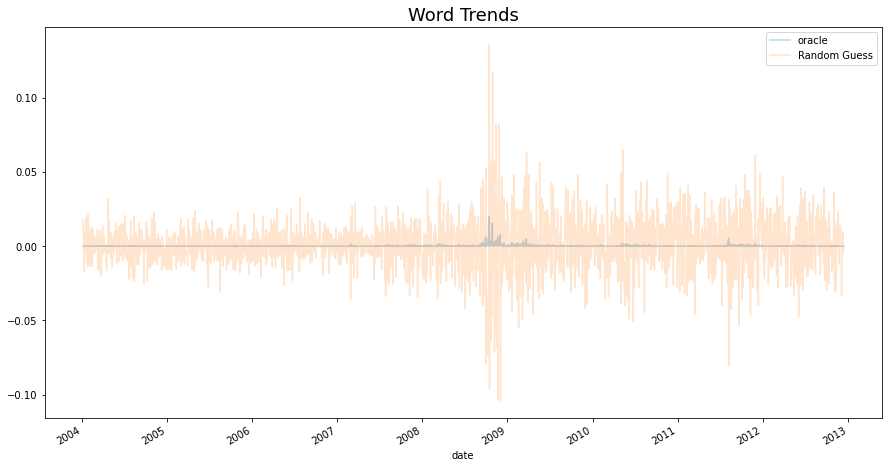

In [85]:
shift = target.shift(1)
means = target.expanding().mean()
stds = target.expanding().std()
preds = []

t = target.index


for t in target.index:

    previous = shift.loc[t]
    mean = means.loc[t]
    std = stds.loc[t]
    pred = previous  + np.random.normal(mean, std,1)
    pred = float(pred)
    preds.append(pred)



preds = pd.DataFrame(preds, columns=["Random Guess"], index=target.index)

oracle = target * target
oracle.columns = ["oracle"]
fig, ax = plt.subplots(figsize=(15,8))
oracle.plot(ax=ax,alpha=0.3);
preds.plot(ax=ax,alpha=0.2);
ax.set_title("Word Trends", fontsize=18);